In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Simulation Modeling using Markov Chain

In [2]:
mlb_19=pd.read_csv('mlb_19.csv').drop('Unnamed: 0', axis=1)

In [3]:
mlb_19_ = mlb_19.copy()


In [4]:
# 현재 State에 대한 정보
mlb_19_['Start1'] = np.where(mlb_19_['on_1b'].isnull(),0,1)
mlb_19_['Start2'] = np.where(mlb_19_['on_2b'].isnull(),0,1)
mlb_19_['Start3'] = np.where(mlb_19_['on_3b'].isnull(),0,1)
mlb_19_['Start_Sum'] = mlb_19_['outs_when_up'] + mlb_19_['Start1'] + mlb_19_['Start2'] + mlb_19_['Start3']
mlb_19_['Start_State'] = (mlb_19_['Start1'].astype(str) + mlb_19_['Start2'].astype(str) + mlb_19_['Start3'].astype(str)+" " + mlb_19_['outs_when_up'].astype(str))

In [5]:
# 현재 타석의 결과(Next State)에 대한 정보
mlb_19_['Next_State'] = mlb_19_['Start_State'].shift(1)
mlb_19_['Next_State'] = mlb_19_['Next_State'].fillna('000 3')

mlb_19_['inning_next'] = mlb_19_['inning_topbot'].shift(1)
mlb_19_['inning_next'] = mlb_19_['inning_next'].fillna(0)

mlb_19_['game_next'] = mlb_19_['game_pk'].shift(1)
mlb_19_['game_next'] = mlb_19_['game_next'].fillna(0)

mlb_19_['Start_Sum'] = mlb_19_['outs_when_up'] + mlb_19_['Start1'] + mlb_19_['Start2'] + mlb_19_['Start3']
mlb_19_['End_Sum'] = mlb_19_['Start_Sum'].shift(1)
mlb_19_['End_Sum'] = mlb_19_['End_Sum'].fillna(0)

# 타석에 의한 득점
mlb_19_['Run_Score'] = mlb_19_['post_bat_score']-mlb_19_['bat_score']

In [6]:
# 타석이 종료된 시점의 데이터
events = mlb_19_[mlb_19_['events'].notnull()]

# 끝내기 안타, 우천 취소 등 일반적이지 않은 상황들 제거
# ex) 1아웃에서 끝내기 안타를 치면 경기가 종료되어 Next State가 3아웃으로 인식
events = events[events['events']!='game_advisory']
events = events[~((events['inning']==9)&(events['inning_topbot']=='Bot')&(events['post_bat_score']>events['post_fld_score']))]
events['Next_State'] = np.where(((events['inning_topbot']!=events['inning_next'])&(events['Next_State']=='000 0')), '000 3', events['Next_State'])
events['Next_State'] = np.where(((events['game_next']!=events['game_pk'])&(events['Next_State']=='000 0')), '000 3', events['Next_State'])
events['End_Sum'] = np.where(events['Next_State']=='000 3', 3, events['End_Sum'])
events['End_Sum'] = events['End_Sum'].astype(float)
events = events[events['End_Sum']-events['Start_Sum']<=1]

In [7]:
# 시작 상황(Start_State)과 타석 결과 상황(Next_State)을 그룹화하여 각 상황 변화 확률 계산
state = events.groupby(['Start_State','Next_State']).agg({'pitch_type': 'count'})
state_pcts = state.groupby(level=0).apply(lambda x: x / float(x.sum()))
state_prob = state_pcts.reset_index().rename(columns={'pitch_type': 'probability'})
state_prob

,Start_State,Next_State,probability
0,000 0,000 0,0.038276
1,000 0,000 1,0.679650
2,000 0,001 0,0.004953
3,000 0,010 0,0.049702
4,000 0,100 0,0.227419
...,...,...,...
281,111 2,011 2,0.024733
282,111 2,100 2,0.001455
283,111 2,101 2,0.044132
284,111 2,110 2,0.035887


In [8]:
# ex) 1사 1루 상황에서의 next_state 확률
state_prob[state_prob['Start_State']=='100 1'].sort_values(by='probability', ascending=False)

,Start_State,Next_State,probability
142,100 1,100 2,0.475338
144,100 1,110 1,0.192676
135,100 1,000 3,0.127351
139,100 1,010 2,0.069696
143,100 1,101 1,0.042395
133,100 1,000 1,0.039014
140,100 1,011 1,0.029776
138,100 1,010 1,0.013939
136,100 1,001 1,0.006021
137,100 1,001 2,0.002887


예를 들어, 1사 1루 상황을 살펴보자. 1사 1루 상황에서는 가장 높은 확률(0.47)로 2사 1루 상황이 되는 것을 확인할 수 있다. 그 다음 확률이 높은 것은 single에 의한 1사 1,2루 상황이 되는 것이다. 병살에 의한 3아웃 상황이 되는 것이 0.13의 확률로 세번째로 높았다. 이렇게 각 상황(start)에서 다음 상황(next)이 될 확률들을 계산하였다.   
    
이제 pivot 기능을 활용해 start에서 next 상황이 될 확률들을 matrix로 표현하였다. index를 start_state, column을 next_state로 하여 각 확률들을 25 x 25 크기의 matrix로 나타내었다.

In [9]:
# matrix table로 표현
pivot_table = state_prob.pivot(index='Start_State', columns='Next_State', values='probability').fillna(0)
cols = [col for col in pivot_table if col !='000 3'] + ['000 3']
P = pivot_table[cols]
last_row = [0]*24 + [1]
P.loc['000 3'] = last_row
P

Next_State,000 0,000 1,000 2,001 0,001 1,001 2,010 0,010 1,010 2,011 0,011 1,011 2,100 0,100 1,100 2,101 0,101 1,101 2,110 0,110 1,110 2,111 0,111 1,111 2,000 3
Start_State,,,,,,,,,,,,,,,,,,,,,,,,,
000 0,0.038276,0.679650,0.000000,0.004953,0.000000,0.000000,0.049702,0.000000,0.000000,0.000000,0.000000,0.000000,0.227419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
000 1,0.000000,0.036004,0.683721,0.000000,0.004560,0.000000,0.000000,0.044650,0.000000,0.000000,0.000000,0.000000,0.000000,0.231065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
000 2,0.000000,0.000000,0.034834,0.000000,0.000000,0.004150,0.000000,0.000000,0.047545,0.000000,0.000000,0.000000,0.000000,0.000000,0.233871,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.679600
001 0,0.044084,0.213457,0.002320,0.002320,0.382831,0.000000,0.051044,0.000000,0.000000,0.000000,0.000000,0.000000,0.171694,0.006961,0.000000,0.125290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
001 1,0.000000,0.035144,0.207668,0.000000,0.005112,0.369329,0.000000,0.057508,0.007668,0.000000,0.000000,0.000000,0.000000,0.168690,0.023003,0.000000,0.114377,0.000000,0.000000,0.001917,0.000000,0.000000,0.000000,0.000000,0.009585
001 2,0.000000,0.000000,0.033607,0.000000,0.000000,0.005080,0.000391,0.000000,0.038687,0.000000,0.000000,0.000000,0.000000,0.000000,0.127394,0.000000,0.000000,0.130520,0.000000,0.000000,0.001563,0.000000,0.000000,0.000000,0.662759
010 0,0.032084,0.005083,0.005718,0.004765,0.211563,0.000000,0.049555,0.423443,0.000000,0.003812,0.000000,0.000000,0.052732,0.010165,0.000000,0.083863,0.000000,0.000000,0.117217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
010 1,0.000000,0.030747,0.003921,0.000000,0.005778,0.176021,0.000000,0.049938,0.450887,0.000000,0.004127,0.000000,0.000000,0.055097,0.008873,0.000000,0.068716,0.000000,0.000000,0.136608,0.000000,0.000000,0.000000,0.000000,0.009286
010 2,0.000000,0.000000,0.030546,0.000000,0.000000,0.006634,0.000154,0.000000,0.059087,0.000000,0.000000,0.000617,0.000000,0.000000,0.079451,0.000000,0.000000,0.029775,0.000000,0.000000,0.122647,0.000000,0.000000,0.000000,0.671089


각 index(start)에서 column(next)으로 갈 확률을 표시하였다. 말이 안되는 것들('000 1'에서 '000 0'으로 갈 확률0)은 모두 확률이 0으로 표시되는 것을 확인할 수 있다.    
   
위의 markov chain matrix는 각 start_state에서 next_state로 갈 수 있는 확률을 나타낸다. 이를 활용해서, '000 0' 상황에서 3번의 타석 후의 상황에 대한 확률들도 계산할 수 있다.

In [10]:
# 3번의 타석 후의 상황에 대한 확률
P_3 = P@P@P
P_3.loc['000 0'].sort_values(ascending=False).reset_index().rename(columns={'Next_State': '3_Next_State', '000 0': 'probability'})

,3_Next_State,probability
0,000 3,0.368123
1,100 2,0.241584
2,110 1,0.080289
3,010 2,0.073375
4,000 2,0.058785
5,101 1,0.027120
6,100 1,0.026632
7,001 2,0.025819
8,000 1,0.023743
9,011 1,0.016247


In [11]:
P_3

Next_State,000 0,000 1,000 2,001 0,001 1,001 2,010 0,010 1,010 2,011 0,011 1,011 2,100 0,100 1,100 2,101 0,101 1,101 2,110 0,110 1,110 2,111 0,111 1,111 2,000 3
Start_State,,,,,,,,,,,,,,,,,,,,,,,,,
000 0,3.924327e-03,2.374298e-02,0.058785,5.240619e-04,0.005950,0.025819,0.002656,0.015856,0.073375,3.048950e-03,0.016247,0.000000,4.056839e-03,2.663202e-02,0.241584,3.848389e-03,0.027120,0.000000,7.825105e-03,0.080289,0.000000,0.010594,0.000000,0.000000,0.368123
000 1,0.000000e+00,3.664593e-03,0.022442,0.000000e+00,0.000648,0.005548,0.000016,0.002637,0.018206,0.000000e+00,0.002863,0.011805,0.000000e+00,3.941980e-03,0.027006,0.000000e+00,0.004003,0.023975,0.000000e+00,0.007237,0.077165,0.000000,0.010457,0.000000,0.778385
000 2,2.873694e-07,4.552387e-08,0.003376,4.267863e-08,0.000002,0.000642,0.000003,0.000004,0.002903,3.414290e-08,0.000000,0.001818,4.723102e-07,9.104774e-08,0.004112,7.511439e-07,0.000000,0.003988,1.049894e-06,0.000000,0.006693,0.000000,0.000000,0.008003,0.968454
001 0,4.890617e-03,2.706374e-02,0.056340,6.553905e-04,0.007283,0.028118,0.003393,0.017450,0.070154,3.888533e-03,0.019415,0.004615,4.913075e-03,2.791412e-02,0.195319,4.712379e-03,0.031328,0.041178,9.207571e-03,0.086206,0.006352,0.014197,0.011842,0.000000,0.323564
001 1,4.668474e-06,4.551536e-03,0.024382,6.933377e-07,0.000823,0.006558,0.000024,0.003327,0.019294,5.546702e-07,0.003531,0.013944,7.672937e-06,4.768668e-03,0.027706,1.220274e-05,0.004968,0.027200,1.705611e-05,0.008694,0.075397,0.000000,0.013443,0.013540,0.747806
001 2,5.241299e-06,1.736552e-05,0.003666,6.691677e-07,0.000008,0.000779,0.000006,0.000028,0.003209,3.723102e-06,0.000007,0.002002,4.748696e-06,3.879456e-05,0.004281,5.710744e-06,0.000035,0.004341,1.486241e-05,0.000041,0.006777,0.000010,0.000000,0.009258,0.965460
010 0,4.151435e-03,2.459952e-02,0.050644,5.536111e-04,0.006856,0.027789,0.003130,0.017052,0.062898,3.308235e-03,0.018337,0.014812,4.204026e-03,2.515932e-02,0.115174,4.090586e-03,0.028434,0.062143,7.784286e-03,0.059375,0.069998,0.012651,0.037005,0.000000,0.339851
010 1,4.438647e-06,4.222912e-03,0.022814,6.592050e-07,0.000733,0.006411,0.000023,0.003129,0.018945,5.273640e-07,0.003099,0.013301,7.295202e-06,4.358927e-03,0.026293,1.160201e-05,0.004616,0.026303,1.621644e-05,0.008121,0.052381,0.000000,0.012422,0.032641,0.760144
010 2,2.344080e-06,6.899202e-06,0.003440,3.050031e-07,0.000005,0.000706,0.000004,0.000015,0.003035,1.502487e-06,0.000003,0.001867,2.326517e-06,1.540263e-05,0.004180,2.973045e-06,0.000014,0.004038,6.871769e-06,0.000016,0.006807,0.000004,0.000000,0.008277,0.967552


'000 0'상황에서 3번의 타석 후 나타나는 상황에 대한 확률들을 계산해보았다. 가장 높은 확률은 바로 3아웃이 되는 상황으로 약 0.37이었다. 그 다음은 0.24의 확률로 2사 1루 상황이 많이 나타났다. 그 다음은 0.01 밑으로 확률로 크게 주는 것을 확인할 수 있는데, 1사 12루, 2사 2루 등의 상황등이 이들에 해당되었다.

----

Markov chain을 이용하면 chain이 어떤 상황에 도달하기까지 State가 평균적으로 몇번 나타났는지를 확인할 수 있다. 야구에서는 '000 3'상황이 되기까지, 즉 이닝이 종료되기까지 각 상황들이 평균적으로 몇번 나타났는지를 확인할 수 있다. 

$$E = (I-Q)^{-1}$$

Q는 P에서 구하고자 하는 상황을 제외한 matrix이고, I는 Q와 크기가 같은 단위행렬이다.
   
'000 3'상황까지 도달하기까지를 계산하기 위해 P에서 '000 3'을 제외한 24x24행렬을 만들었고, 위 식으로 E matrix를 계산하였다.

In [12]:
Q = P.iloc[:24, :24]
I = np.eye(24)
e = np.linalg.inv(I-Q)
columns = Q.columns
index = Q.index
E = pd.DataFrame(e, columns=columns, index=index)

In [13]:
E

Next_State,000 0,000 1,000 2,001 0,001 1,001 2,010 0,010 1,010 2,011 0,011 1,011 2,100 0,100 1,100 2,101 0,101 1,101 2,110 0,110 1,110 2,111 0,111 1,111 2
Start_State,,,,,,,,,,,,,,,,,,,,,,,,
000 0,1.056545e+00,7.717675e-01,0.610477,7.362613e-03,0.026492,0.046508,0.061407,0.096987,0.122602,1.330582e-02,2.855247e-02,0.032023,2.456661e-01,0.308689,0.318645,1.904484e-02,0.045298,0.062172,0.064193,0.111202,0.133437,1.655905e-02,3.808421e-02,0.046593
000 1,1.230163e-06,1.053415e+00,0.770479,1.736725e-07,0.007362,0.022347,0.000026,0.055998,0.099359,4.395166e-07,1.128750e-02,0.020038,1.688057e-06,0.248556,0.315311,2.478976e-06,0.019461,0.040722,0.000004,0.061675,0.104283,1.076170e-06,1.586513e-02,0.029235
000 2,6.266557e-07,1.128504e-06,1.050867,8.847027e-08,0.000003,0.007142,0.000013,0.000006,0.061359,2.238935e-07,5.973371e-07,0.008100,8.599108e-07,0.000002,0.252380,1.262812e-06,0.000002,0.017949,0.000002,0.000002,0.057694,5.482102e-07,9.846259e-07,0.011713
001 0,6.664104e-02,3.126188e-01,0.380443,1.005141e+00,0.410476,0.194859,0.064975,0.103157,0.128067,1.641818e-02,4.006367e-02,0.041319,1.923963e-01,0.271251,0.291852,1.475459e-01,0.132530,0.111114,0.076408,0.127575,0.145058,3.045964e-02,5.824863e-02,0.063568
001 1,8.782575e-06,5.595458e-02,0.295307,1.239910e-06,1.009177,0.396306,0.000182,0.071056,0.109634,3.137867e-06,1.402937e-02,0.027098,1.205164e-05,0.188090,0.268434,1.769830e-05,0.138511,0.126821,0.000028,0.070973,0.114264,7.683163e-06,3.066446e-02,0.048060
001 2,2.056211e-05,3.702900e-05,0.050312,2.902927e-06,0.000096,1.008430,0.000427,0.000208,0.052561,7.346497e-06,1.960010e-05,0.009728,2.821578e-05,0.000062,0.145388,4.143595e-05,0.000056,0.149577,0.000066,0.000080,0.053105,1.798812e-05,3.230799e-05,0.027366
010 0,5.113328e-02,9.208268e-02,0.181366,7.218917e-03,0.239813,0.214399,1.062203,0.516409,0.309065,1.826906e-02,4.874097e-02,0.049658,7.016622e-02,0.154086,0.208846,1.030418e-01,0.138029,0.129528,0.164770,0.198814,0.186202,4.473236e-02,8.034261e-02,0.081688
010 1,8.369849e-06,4.947160e-02,0.085440,1.181642e-06,0.009226,0.202692,0.000174,1.063164,0.547735,2.990406e-06,1.822088e-02,0.033856,1.148529e-05,0.072863,0.153060,1.686659e-05,0.089716,0.112498,0.000027,0.181525,0.192916,7.322102e-06,4.791193e-02,0.065444
010 2,8.661949e-06,1.559875e-05,0.046677,1.222880e-06,0.000041,0.009761,0.000180,0.000087,1.073466,3.094769e-06,8.256692e-06,0.009068,1.188612e-05,0.000026,0.098434,1.745522e-05,0.000023,0.048677,0.000028,0.000034,0.162299,7.577636e-06,1.360999e-05,0.030680


이제 각 시작 상황에 대해 '000 3'상황이 되기까지 각 상황이 평균적으로 몇번 등장하는지 알 수 있다.   
아래는 '000 0'상황에서 '000 3'상황이 되기까지 각 상황이 평균적으로 몇번 등장했는지를 확인해보았다.

In [37]:
E_0000 = E.loc['000 0']
E_0000.reset_index().rename(columns={'Next_State': 'State', '000 0': 'average'})

,State,average
0,000 0,1.056545
1,000 1,0.771768
2,000 2,0.610477
3,001 0,0.007363
4,001 1,0.026492
5,001 2,0.046508
6,010 0,0.061407
7,010 1,0.096987
8,010 2,0.122602
9,011 0,0.013306


'000 0'상황은 약 1.06번 등장했다. 홈런에 의한 것으로 보인다. 그다음 많이 등장하는 것은 '000 1'상황으로 약 0.77번 등장했다. 이런 식으로 각 상황이 평균적으로 몇번 등장했는지 확인할 수 있고, 이것들을 다 더하면 한 이닝에 평균적으로 몇번의 타석이 등장했는지를 확인할 수 있다.

In [15]:
E_0000.sum()

4.2836130261404755

다 더한 결과, 약 4.28이 나왔고, 이는 '000 0' 상황에서 '000 3'상황이 되기까지, 즉 한 이닝이 시작하고 끝날때까지 약 4.28의 타석이 존재했다는 것을 의미한다.

In [16]:
E.sum(axis=1).reset_index().rename(columns={0: 'average_PA'}).sort_values(by='average_PA', ascending=False)

,Start_State,average_PA
3,001 0,4.412185
9,011 0,4.405813
6,010 0,4.350603
0,000 0,4.283613
15,101 0,4.150530
18,110 0,4.094889
21,111 0,4.094266
12,100 0,4.077403
10,011 1,2.979131
4,001 1,2.964639


In [17]:
# 각 상황 변화에 따른 득점
state_score = events.groupby(['Start_State','Next_State']).agg({'pitch_type': 'count', 'Run_Score': 'mean'}).rename(columns={'pitch_type': 'count'}).reset_index()
state_score['Run_Score'] = round(state_score['Run_Score'])
state_score

,Start_State,Next_State,count,Run_Score
0,000 0,000 0,1762,1.0
1,000 0,000 1,31287,0.0
2,000 0,001 0,228,0.0
3,000 0,010 0,2288,0.0
4,000 0,100 0,10469,0.0
...,...,...,...,...
281,111 2,011 2,51,2.0
282,111 2,100 2,3,3.0
283,111 2,101 2,91,2.0
284,111 2,110 2,74,2.0


In [18]:
state_run_prob = pd.merge(state_score, state_prob, on=['Start_State', 'Next_State'])
state_run_prob['run_prob'] = state_run_prob['Run_Score']*state_run_prob['probability']
state_r_step = state_run_prob.groupby('Start_State').agg({'run_prob': 'sum'}).reset_index()
state_r_step

,Start_State,run_prob
0,000 0,0.038276
1,000 1,0.036004
2,000 2,0.034834
3,001 0,0.526682
4,001 1,0.511182
5,001 2,0.239937
6,010 0,0.176302
7,010 1,0.176228
8,010 2,0.206263
9,011 0,0.685535


In [19]:
r_step = pd.Series(state_r_step['run_prob'])
re_matrix = pd.DataFrame(np.array(E)).dot(r_step)
re = pd.DataFrame(np.array(re_matrix), index=index, columns=['RE']).reset_index()
re

,Start_State,RE
0,000 0,0.513396
1,000 1,0.275002
2,000 2,0.107250
3,001 0,1.413783
4,001 1,0.948550
5,001 2,0.351179
6,010 0,1.128869
7,010 1,0.673477
8,010 2,0.315812
9,011 0,2.011043


In [20]:
states = np.array(index)
states = np.append(states, '000 3')

In [57]:
count=0
score_dist=[]
for _ in range(10000):
    start = '000 1'
    score=0
    state_list = [start]
    score_list = [score]
    while start!='000 3':
        current = np.random.choice(states, p=P.loc[start])
        score = score + state_score[(state_score['Start_State']==start)&(state_score['Next_State']==current)]['Run_Score'].iloc[0]
        start = current
        #state_list.append(start)
        #score_list.append(score)
    score_dist.append(score)

In [22]:
score_count = pd.DataFrame({'score': score_dist}).value_counts().reset_index().rename(columns={0: 'count'})
score_count

,score,count
0,0.0,8295
1,1.0,1000
2,2.0,437
3,3.0,163
4,4.0,70
5,5.0,22
6,6.0,6
7,7.0,5
8,8.0,2


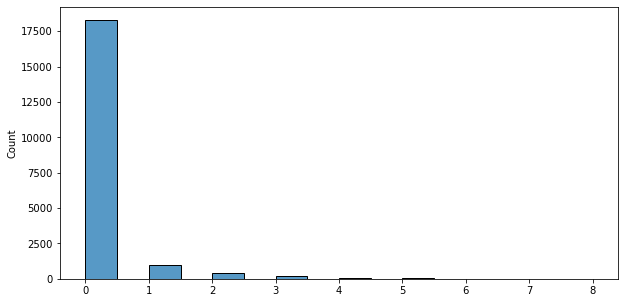

In [35]:
plt.figure(figsize=(10,5))
sns.histplot(score_dist)
plt.show()

In [24]:
for _ in range(10000):
    home_start = '000 0'
    inning=1
    home_score=0
    away_score=0
    state_list = [start]
    score_list = [score]
    while inning<10:
        while home_start!='000 3':
            home_current = np.random.choice(states, p=P.loc[home_start])
            home_score = home_score + state_score[(state_score['Start_State']==home_start)&(state_score['Next_State']==home_current)]['Run_Score'].iloc[0]
            home_start = home_current
        inning += 1
    score_dist.append(score)



In [25]:
test_states = np.delete(states, -1)

In [26]:
test_states

array(['000 0', '000 1', '000 2', '001 0', '001 1', '001 2', '010 0',
       '010 1', '010 2', '011 0', '011 1', '011 2', '100 0', '100 1',
       '100 2', '101 0', '101 1', '101 2', '110 0', '110 1', '110 2',
       '111 0', '111 1', '111 2'], dtype=object)

In [27]:
home_win_prob=[]
for away_start_1 in test_states:
    home_win_count=0
    away_win_count=0
    for _ in range(10):    
        away_score=0
        home_score=0
        while away_start_1!='000 3':
                away_current = np.random.choice(states, p=P.loc[away_start_1])
                away_score = away_score + state_score[(state_score['Start_State']==away_start_1)&(state_score['Next_State']==away_current)]['Run_Score'].iloc[0]
                away_start_1 = away_current  

        inning=2
        while inning<10:
            away_start = '000 0'
            while away_start!='000 3':
                away_current = np.random.choice(states, p=P.loc[away_start])
                away_score = away_score + state_score[(state_score['Start_State']==away_start)&(state_score['Next_State']==away_current)]['Run_Score'].iloc[0]
                away_start = away_current
            inning += 1

        inning=1
        home_score=0
        while inning<10:
            home_start = '000 0'
            while home_start!='000 3':
                home_current = np.random.choice(states, p=P.loc[home_start])
                home_score = home_score + state_score[(state_score['Start_State']==home_start)&(state_score['Next_State']==home_current)]['Run_Score'].iloc[0]
                home_start = home_current
            inning += 1

        if home_score>away_score:
            home_win_count +=1
        elif home_score<away_score:
            away_win_count +=1
    home_win_p = home_win_count/(home_win_count+away_win_count)
    home_win_prob.append(home_win_p)

In [28]:
away = []
home = []
away_score=0
home_score=0
away_start_1 = '000 0'
while away_start_1!='000 3':
    away_current = np.random.choice(states, p=P.loc[away_start_1])
    away_score = away_score + state_score[(state_score['Start_State']==away_start_1)&(state_score['Next_State']==away_current)]['Run_Score'].iloc[0]
    away_start_1 = away_current
away.append(away_score)

inning=2
while inning<10:
    away_start = '000 0'
    while away_start!='000 3':
        away_current = np.random.choice(states, p=P.loc[away_start])
        away_score = away_score + state_score[(state_score['Start_State']==away_start)&(state_score['Next_State']==away_current)]['Run_Score'].iloc[0]
        away_start = away_current
    print(away_score)
    inning += 1

inning=1
home_score=0
home_start = '000 0'
while inning<10:
    while home_start!='000 3':
        home_current = np.random.choice(states, p=P.loc[home_start])
        home_score = home_score + state_score[(state_score['Start_State']==home_start)&(state_score['Next_State']==home_current)]['Run_Score'].iloc[0]
        home_start = home_current
    home.append(home_score)
    inning += 1

away_score

0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0


1.0

In [29]:
away

[0.0]

In [30]:
home

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [31]:
inning=2

while inning<10:
    away_start = '000 0'
    away_inning_score=0
    while away_start!='000 3':
        away_current = np.random.choice(states, p=P.loc[away_start])
        away_inning_score = away_inning_score + state_score[(state_score['Start_State']==away_start)&(state_score['Next_State']==away_current)]['Run_Score'].iloc[0]
        away_start = away_current
    print(away_inning_score)
    away.append(away_score)
    inning += 1

0.0
0.0
1.0
0.0
0.0
0.0
0.0
4.0


In [32]:
away

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]